# Imports

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")
plt.rcdefaults()

# Defining the Directories

In [2]:
sequence = "h13_short"
DATA_DIR = '../../data/extracted_images/' + sequence
RESULT_DIR = '../../data/results/' + sequence

# Getting Informations and Reading the Files

## Getting Frame Information

In [3]:
info_dict = {
    "first_frame": 1,
    "last_frame": 2,
    "contact_frame": 3,
    "leave_frame": 4,
    "angle": 5,
    "passthrough": 6,
}

In [4]:
def get_info(file):
    information = {}
    with open(file, "r") as f:
        texts = f.readlines()
    for key, value in info_dict.items():
        line = texts[value]
        info = line.split(":")[1].strip()
        information[key] = info
    return information

information = get_info(f"{DATA_DIR}.txt")

In [5]:
first_frame = DATA_DIR + "/" +information["first_frame"]
last_frame = DATA_DIR + "/" +information["last_frame"]
contact_frame = DATA_DIR + "/" +information["contact_frame"]
angle = information["angle"]
leave_frame = DATA_DIR + "/" +information["leave_frame"]
passthrough = information["passthrough"]

In [6]:
first_frame, last_frame

('../../data/extracted_images/h13_short/010',
 '../../data/extracted_images/h13_short/161')

## Converting the Frame ID to Integer

In [7]:
reg = re.compile(r"\d{3}")
first_frame_num = int(reg.findall(first_frame)[0])
contact_frame_num = int(reg.findall(contact_frame)[0])
leave_frame_num = int(reg.findall(leave_frame)[0])
first_frame_num, contact_frame_num, leave_frame_num

(10, 77, 116)

## Reading the DF

In [8]:
df_name = sequence+"_raw.csv"
df = pd.read_csv(RESULT_DIR + '/'+df_name)
df_c = df[df["x"].notna()]

# Fitting Curves

## The Curves to be Fitted

We'll assume that downward is the positive direction. In this way, the gravitational acceleration is positive. In x direction, no force is acting and hence the equation of motion is simply:
$$
x(t) = x_0 + v_{x0}t
$$
Here $x_0$ is the initial x position, $v_{x0}$ is the initial y velocity.

Now, in y direction, the equation of motion is:
$$
y(t) = y_0 + v_{y0}t + \frac{1}{2}gt^2
$$
Here, $y_0$ is the initial y position, $v_{y0}$ is the initial y velocity, and $g$ is the acceleration due to gravity.

We'll optimize these two equations to get the initial velocity and the initial position for x and y direction.

We can also phrase the same problem by eliminating $t$ from the equation of motions. This way, we'll get $y$ as a function of $x$. Eliminating $t$ from the equation of motion, we get:
$$
y = y_0 + \frac{v_y}{v_x}(x - x_0) + \frac{1}{2}g\frac{(x - x_0)^2}{v_x^2}
$$


Here, we have rewritten $v_{x0}$ as $v_x$ and $v_{y0}$ as $v_y$. 
<!-- Defining $\frac{v_y}{v_x}$ as $m$, which is nothing but $\tan(\theta)$ where $\theta$ is the angle between the y and x velocity, we get:
$$
y = y_0 + m(x - x_0) + \frac{1}{2}g\frac{(x - x_0)^2}{v_x^2}
$$ -->

This is a parabola with the parameters $y_0$, $m$, $g$ and $v_x$ and $v_y$. We can use `scipy` to get these parameters.

In [9]:
def the_parabola(x, x0, y0, vy, vx, g):
    second_term = (vy/vx)*(x-x0)
    third_term = 0.5*g*((x-x0)/vx)**2
    return y0 + second_term + third_term
the_parabola_vector = np.vectorize(the_parabola)

However, it turned out that using the parabola does not give a reasonable result. So, we'll be using the parametric equations.

In [10]:
def parametric_x(t, x0, vx0):
    return x0 + vx0*t
parametric_x_vector = np.vectorize(parametric_x)

def parametric_y(t, y0, vy0, g):
    return y0 + vy0*t+0.5*g*t**2
parametric_y_vector = np.vectorize(parametric_y)

## Region III

### Data For Region III

In [11]:
region_3 = df_c[df_c["Region"] == "III"]

In [12]:
X = region_3["x"].values
Y = region_3["y"].values
t = region_3["time"].values
offset = t[0]
tbar = t-offset

In [13]:
tbar

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 15, 16, 17, 18,
       19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57])

### Fitting the Curves

In [14]:
popt, pcov = curve_fit(the_parabola, X, Y, maxfev=10000)
popty, pcovy = curve_fit(parametric_y, tbar, Y)
poptx, pcovx = curve_fit(parametric_x, tbar, X)

In [15]:
popt

array([1681.50389291,  944.33134675,   59.15454777,   46.50681486,
          5.02018294])

As you can see, the parameters calculated by the fitting method is ridiculus, even though it fits the parabola well (See the figure below).

In [16]:
poptx, popty

(array([886.1477875 ,   5.47382932]),
 array([ 6.64416807e+02, -2.92565913e+00,  6.26670998e-02]))

These values are reasonable.

In [17]:
g = popty[2]
g

0.06266709979790797

### Analyzing the Results

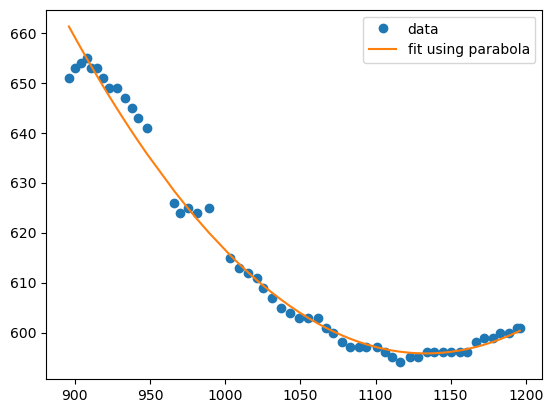

In [18]:
plt.plot(X,Y, 'o', label="data")
plt.plot(X, the_parabola_vector(X, *popt),label="fit using parabola")
plt.legend();

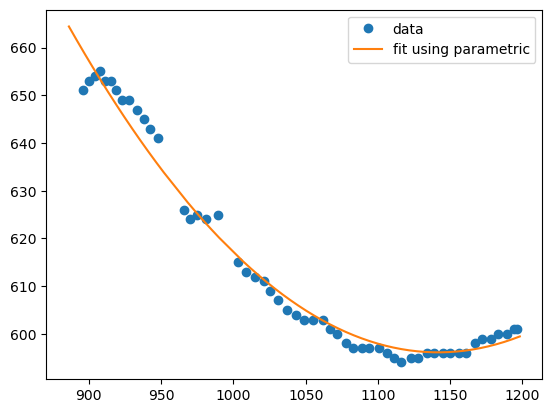

In [19]:
plt.plot(X,Y, 'o', label="data")
plt.plot(parametric_x_vector(tbar, *poptx), parametric_y_vector(tbar, *popty), label="fit using parametric")
plt.legend();

We can see that using the parametric equations, we can fit the curve accurately.

### Getting Speeds

Next, we'll see how the calculated velocities are? The eqaution for the speeds are:
$$
v_x(t) = v_{x0}\\
v_y(t) = v_{y0} + gt
$$

In [20]:
vy = popty[1]+popty[2]*(tbar)
vx = np.ones(len(tbar))*poptx[1]
v = np.sqrt(vy**2+vx**2)

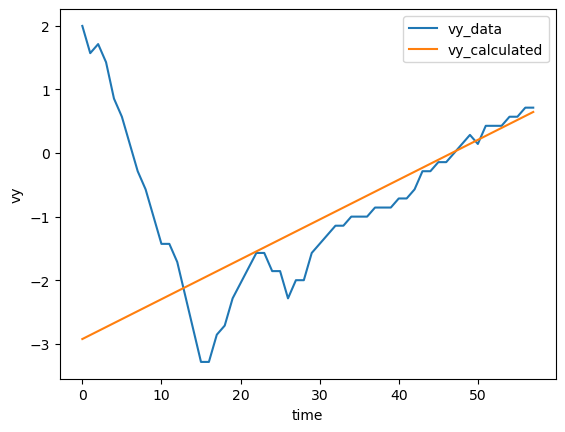

In [21]:
plt.plot(tbar, region_3["vy"].values, label="vy_data")
plt.plot(tbar, vy, label="vy_calculated")
plt.legend()
plt.xlabel("time")
plt.ylabel("vy");

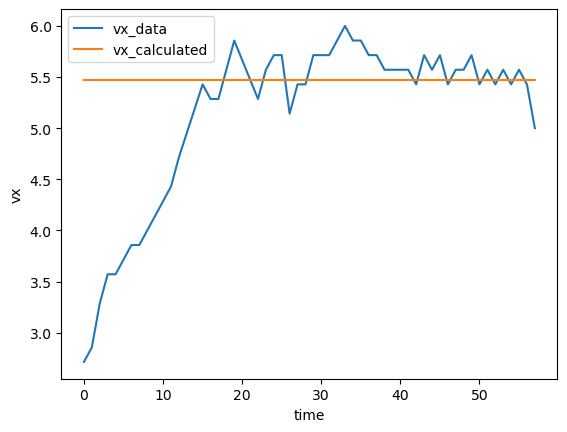

In [22]:
plt.plot(tbar, region_3["vx"].values, label="vx_data")
plt.plot(tbar, vx, label="vx_calculated")
plt.legend()
plt.xlabel("time")
plt.ylabel("vx");

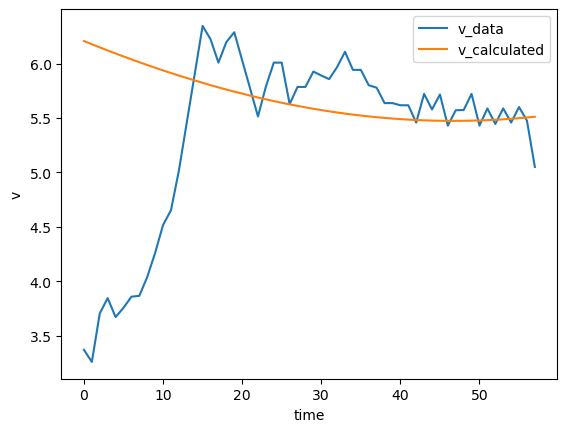

In [23]:
plt.plot(tbar, region_3["v"].values, label="v_data")
plt.plot(tbar, v, label="v_calculated")
plt.legend()
plt.xlabel("time")
plt.ylabel("v");

They are reasonable.

### Getting Angles

Next, let's calculate the angle between the x and y velocity.

In [24]:
angles= np.arctan(vy/vx)*180/np.pi

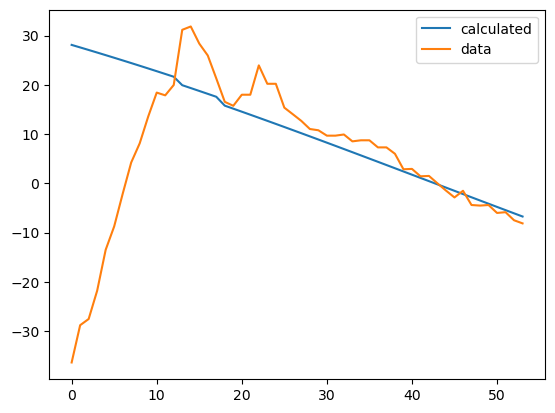

In [25]:
plt.plot(-angles, label = "calculated")
plt.plot(region_3["angle"].values, label = "data")
plt.legend();

Again, reasonable.

## Getting the Additional Information

In [26]:
new_info_df = pd.DataFrame({"vx": vx, "vy": vy, "v":v, "angle": angles, "time":t})
new_info_df.columns = ["vx_using_curve", "vy_using_curve", "v_using_curve", "angle_using_curve", "time"]

In [27]:
new_info_df

,vx_using_curve,vy_using_curve,v_using_curve,angle_using_curve,time
0,5.473829,-2.925659,6.206633,-28.123668,98
1,5.473829,-2.862992,6.177340,-27.611041,99
2,5.473829,-2.800325,6.148547,-27.093571,100
3,5.473829,-2.737658,6.120260,-26.571274,101
4,5.473829,-2.674991,6.092486,-26.044171,102
5,5.473829,-2.612324,6.065232,-25.512286,103
6,5.473829,-2.549657,6.038506,-24.975646,104
7,5.473829,-2.486989,6.012314,-24.434283,105
8,5.473829,-2.424322,5.986664,-23.888232,106
9,5.473829,-2.361655,5.961562,-23.337532,107


In [28]:
df_final = pd.merge(df_c, new_info_df, on="time", how="left")
df_final.tail().T

,138,139,140,141,142
id,../../data/extracted_images/h13_short/151.jpg,../../data/extracted_images/h13_short/152.jpg,../../data/extracted_images/h13_short/153.jpg,../../data/extracted_images/h13_short/154.jpg,../../data/extracted_images/h13_short/155.jpg
x,1178.0,1183.0,1189.0,1194.0,1196.0
y,599.0,600.0,600.0,601.0,601.0
r1,11.0,9.0,10.0,9.0,6.0
r2,9.0,11.0,10.0,10.0,9.0
theta,50.993244,-31.512679,84.224796,39.534088,19.480565
vx,5.571429,5.428571,5.571429,5.428571,5.0
vy,0.428571,0.571429,0.571429,0.714286,0.714286
v,5.587888,5.458564,5.600656,5.475362,5.050763
angle,-4.398705,-6.009006,-5.856014,-7.495858,-8.130102


## Adding the Additional Information

In [29]:
x_speed = vx[0]
y_speed = vy[0]
speed = v[0]
angle = angles[0]
x_speed, y_speed, speed, angle

(5.473829321828268, -2.925659126300037, 6.206632643214001, -28.123668054758)

In [30]:
pattern = "***"
information = f"""USING CURVE FIT AT LEAVE FRAME
### ANGLE: {np.round(angle, 2)}
### VELOCITY: {np.round(speed, 2)}
### X VELOCITY: {np.round(x_speed, 2)}
### Y VELOCITY: {np.round(y_speed, 2)}
### g: {np.round(g, 4)}
{pattern*20}
"""
print(information)

USING CURVE FIT AT LEAVE FRAME
### ANGLE: -28.12
### VELOCITY: 6.21
### X VELOCITY: 5.47
### Y VELOCITY: -2.93
### g: 0.0627
************************************************************



First, create a new string containing just the previous text file. Else we'll duplicate the text file.

In [31]:
with open(RESULT_DIR +"/info.txt", "r+") as f:
    texts = f.readlines()
if len(texts)>44:
    text = "".join(texts[:-6])
else:
    text = "".join(texts)
print(text[:125])
all_text = text+information

### h13_short.tif
### First Frame ID: 010
### Last Frame ID: 161
### Contact Frame ID: 077
### Leave Frame ID: 097
### Angle:


In [32]:
len(texts)

43

In [33]:
with open(RESULT_DIR +"/info.txt", "w") as f:
    f.writelines(all_text)

### Save the DataFrame

In [34]:
df_final.to_csv(RESULT_DIR + f"/{sequence}_final.csv", index=False)